In [8]:
import operator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [9]:
#Loading data
future_values = pd.read_csv('future_values.csv',parse_dates = ['date']).rename(columns={'date':'ds','store_id':'unique_id'})
metadata = pd.read_csv('metadata.csv').rename(columns={'store_id':'unique_id'})
sales_data = pd.read_csv('sales_data.csv',parse_dates = ['date']).rename(columns={'date':'ds','store_id':'unique_id','sales':'y'})
sales_data.dtypes

C:\Users\pc\AppData\Local\Temp\ipykernel_18676\594441786.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_data = pd.read_csv('sales_data.csv',parse_dates = ['date']).rename(columns={'date':'ds','store_id':'unique_id','sales':'y'})


unique_id                 object
ds                datetime64[ns]
y                          int64
customers                  int64
open                       int64
promo                      int64
state_holiday             object
school_holiday             int64
dtype: object

In [10]:
# Grouping data by each time series
grouped = sales_data.groupby('unique_id')

print("\nDate range per unique_id:")
date_range = sales_data.groupby('unique_id')['ds'].agg(['min', 'max', 'count'])
print(date_range)

# Creating a summary dataframe for visualizing data completeness
summary = grouped.agg(
    count_observed=('ds', 'count'),
    start_date=('ds', 'min'),
    end_date=('ds', 'max')
).reset_index()

summary['expected_count'] = (
    (summary['end_date'].dt.to_period('M') - summary['start_date'].dt.to_period('M')).apply(lambda x: x.n) + 1
)

# Identifying which time series are irregular
summary['is_irregular'] = summary['count_observed'] < summary['expected_count']

filtered = summary[summary['is_irregular'] == True]
display(filtered)


Date range per unique_id:
                 min        max  count
unique_id                             
store_1   2013-01-07 2015-07-19    924
store_10  2013-01-07 2015-07-19    924
store_100 2013-01-07 2015-07-19    924
store_101 2013-01-07 2015-07-19    924
store_102 2013-01-07 2015-07-19    924
...              ...        ...    ...
store_95  2013-01-07 2015-07-19    924
store_96  2013-01-07 2015-07-19    924
store_97  2013-01-07 2015-07-19    924
store_98  2013-01-07 2015-07-19    924
store_99  2013-01-07 2015-07-19    924

[676 rows x 3 columns]


,unique_id,count_observed,start_date,end_date,expected_count,is_irregular


In [ ]:
#Checking na
future_values.isna ().sum ()
metadata.isna ().sum ()
sales_data.isna().sum()

In [11]:
sales_merged = pd.merge(sales_data, metadata, on='unique_id', how='left')
future_merged = pd.merge(future_values, metadata, on='unique_id', how='left')
sales_merged.head()

,unique_id,ds,y,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance
0,store_1,2015-07-19,0,0,0,0,0,0,c,a,1270.0
1,store_2,2015-07-19,0,0,0,0,0,0,a,a,14130.0
2,store_3,2015-07-19,0,0,0,0,0,0,a,c,24000.0
3,store_4,2015-07-19,0,0,0,0,0,0,a,a,7520.0
4,store_5,2015-07-19,0,0,0,0,0,0,a,c,2030.0


In [12]:
import pandas as pd

# Ensure datetime
sales_merged['ds'] = pd.to_datetime(sales_merged['ds'])

# Create a weekly bucket
sales_merged['week'] = sales_merged['ds'].dt.to_period('W-MON').dt.start_time

# Make sure state_holiday is string type
sales_merged['state_holiday'] = sales_merged['state_holiday'].astype(str)

# Count how many times each state_holiday type appears per week per store
holiday_counts = (
    sales_merged
    .groupby(['unique_id', 'week', 'state_holiday'])
    .size()
    .unstack(fill_value=0)  # turns into columns
    .reset_index()
    .rename_axis(None, axis=1)  # remove column name
)

# Optional: Rename columns for clarity
holiday_counts.columns = ['unique_id', 'week'] + [f'state_holiday_{col}' for col in holiday_counts.columns[2:]]

# Now aggregate your normal weekly data
weekly_data = sales_merged.groupby(['unique_id', 'week'], as_index=False).agg({
    'y': 'sum',
    'customers': 'sum',
    'promo': 'sum',
    'open': 'sum',
    'school_holiday': 'sum',
    'store_type': 'first',
    'assortment': 'first',
    'competition_distance': 'first'
})

# Merge the holiday counts in
weekly_data = weekly_data.merge(holiday_counts, on=['unique_id', 'week'], how='left')

# Fill in 0 where a holiday type didn’t occur that week
weekly_data.fillna(0, inplace=True)

weekly_data.head()

,unique_id,week,y,customers,promo,open,school_holiday,store_type,assortment,competition_distance,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
0,store_1,2013-01-01,7176,785,1,1,1,c,a,1270.0,1,0,0,0
1,store_1,2013-01-08,30493,3749,4,6,4,c,a,1270.0,7,0,0,0
2,store_1,2013-01-15,26655,3408,1,6,0,c,a,1270.0,7,0,0,0
3,store_1,2013-01-22,31732,3804,4,6,0,c,a,1270.0,7,0,0,0
4,store_1,2013-01-29,31670,3774,1,6,0,c,a,1270.0,7,0,0,0


In [ ]:
filtered_values = np.where((weekly_data['state_holiday_a']>0) & (weekly_data['state_holiday_b']> 0) & (weekly_data['state_holiday_c']>0))
print(filtered_values)
display(weekly_data.loc[filtered_values])

In [40]:
import numpy as np
from statsmodels.tsa.seasonal import STL

# Function to quantify seasonality strength and residual variability
def quantify_seasonality_and_residual(weekly_data, seasonal_period=52, lo_frac=0.4):
    # Ensure datetime index
    ts = weekly_data.set_index("ds").sort_index()

    # Run STL decomposition with safe parameters
    stl = STL(ts["y"], period=seasonal_period, robust=True, seasonal=7, trend=53)
    result = stl.fit()
    
    # Strength of seasonality: as per formula
    fs = max(0, 1 - np.var(result.resid) / np.var(result.resid + result.seasonal))

    # Residual variability
    rv = np.std(result.resid) / ts["y"].mean()

    return pd.Series({
        "strength_seasonality": round(fs, 2),
        "residual_variability": round(rv, 2)
    })
# Apply to each product
sales_data["ds"] = pd.to_datetime(sales_data["ds"])

seasonality_metrics = sales_data.groupby("unique_id").apply(
    lambda x: quantify_seasonality_and_residual(x, seasonal_period=52)
).reset_index()

print(seasonality_metrics)

KeyboardInterrupt: 

In [47]:
import numpy as np
from statsmodels.tsa.seasonal import STL

# Function to quantify seasonality strength and residual variability
def quantify_seasonality_and_residual(ts, seasonal_period=52, lo_frac=0.4):
    # Ensure datetime index
    #ts = weekly_data.set_index("ds").sort_index()

    # Run STL decomposition with safe parameters
    stl = STL(ts["y"], period=seasonal_period, robust=True, seasonal=7, trend=53)
    result = stl.fit()
    
    # Strength of seasonality: as per formula
    fs = max(0, 1 - np.var(result.resid) / np.var(result.resid + result.seasonal))

    # Residual variability
    rv = np.std(result.resid) / ts["y"].mean()

    return pd.Series({
        "strength_seasonality": round(fs, 2),
        "residual_variability": round(rv, 2)
    })

seasonality_metrics = weekly_data.groupby("unique_id").apply(
    lambda x: quantify_seasonality_and_residual(x, seasonal_period=52)
).reset_index()

print(seasonality_metrics)

     unique_id  strength_seasonality  residual_variability
0      store_1                  0.91                  0.05
1     store_10                  0.98                  0.02
2    store_100                  0.95                  0.03
3    store_101                  0.84                  0.05
4    store_102                  0.89                  0.05
..         ...                   ...                   ...
671   store_95                  0.88                  0.06
672   store_96                  0.96                  0.03
673   store_97                  0.38                  0.16
674   store_98                  0.85                  0.06
675   store_99                  0.91                  0.04

[676 rows x 3 columns]


C:\Users\pc\AppData\Local\Temp\ipykernel_18676\1848816303.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonality_metrics = weekly_data.groupby("unique_id").apply(


In [ ]:
import numpy as np
from statsmodels.tsa.seasonal import STL

# Function to quantify seasonality strength and residual variability
def quantify_seasonality_and_residual(ts, seasonal_period=52, lo_frac=0.4):
    # Ensure datetime index
    #ts = weekly_data.set_index("ds").sort_index()

    # Run STL decomposition with safe parameters
    stl = STL(ts["y"], period=seasonal_period, robust=True, seasonal=21, trend=53)
    result = stl.fit()
    
    # Strength of seasonality: as per formula
    fs = max(0, 1 - np.var(result.resid) / np.var(result.resid + result.seasonal))

    # Residual variability
    rv = np.std(result.resid) / ts["y"].mean()

    return pd.Series({
        "strength_seasonality": round(fs, 2),
        "residual_variability": round(rv, 2)
    })

seasonality_metrics = weekly_data.groupby("unique_id").apply(
    lambda x: quantify_seasonality_and_residual(x, seasonal_period=52)
).reset_index()

print(seasonality_metrics)

     unique_id  strength_seasonality  residual_variability
0      store_1                  0.95                  0.04
1     store_10                  0.98                  0.02
2    store_100                  0.94                  0.03
3    store_101                  0.84                  0.05
4    store_102                  0.93                  0.04
..         ...                   ...                   ...
671   store_95                  0.89                  0.06
672   store_96                  0.95                  0.03
673   store_97                  0.43                  0.15
674   store_98                  0.86                  0.06
675   store_99                  0.91                  0.04

[676 rows x 3 columns]


C:\Users\pc\AppData\Local\Temp\ipykernel_18676\4046766329.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonality_metrics = weekly_data.groupby("unique_id").apply(


In [36]:
import numpy as np
from statsmodels.tsa.seasonal import STL

# Function to quantify seasonality strength and residual variability
def quantify_fs_rv(weekly_data: pd.DataFrame, seasonality_period : int, lo_frac: float):
    stl= STL(seasonality_period = seasonality_period, model= "additive", lo_frac=lo_frac)
    decomposed_ts = stl.fit(weekly_data.set_index("ds").drop(columns="unique_id"))
    fs= max(0, 1-np.var(decomposed_ts.resid["y"])/
                        np.var(decomposed_ts.resid["y"]+decomposed_ts.seasonal["y"]))
    rv = np.std(decomposed_ts.resid["y"])/ts["y"].mean
    return pd.Series(
        {"strength_seasonality": round(fs,2),"residual_variability":round(rv,2)}
    )
    
sales_data["ds"] = pd.to_datetime(sales_data["ds"])

seasonality_metrics = sales_data.groupby("unique_id").apply(
    lambda x: quantify_fs_rv(x, seasonality_period=52,lo_frac=0.4)
).reset_index()

print(seasonality_metrics)
        




TypeError: __init__() got an unexpected keyword argument 'seasonality_period'

In [37]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL

# Function to quantify seasonality strength and residual variability
def quantify_fs_rv(weekly_data: pd.DataFrame, seasonality_period: int, lo_frac: float):
    ts = weekly_data.set_index("ds").sort_index()["y"]

    # Initialize STL correctly
    stl = STL(ts, period=seasonality_period, robust=True)
    decomposed_ts = stl.fit()

    # Strength of seasonality
    fs = max(0, 1 - np.var(decomposed_ts.resid) / 
                 np.var(decomposed_ts.resid + decomposed_ts.seasonal))

    # Residual variability
    rv = np.std(decomposed_ts.resid) / ts.mean()

    return pd.Series({
        "strength_seasonality": round(fs, 2),
        "residual_variability": round(rv, 2)
    })
sales_data["ds"] = pd.to_datetime(sales_data["ds"])

seasonality_metrics = sales_data.groupby("unique_id").apply(
    lambda x: quantify_fs_rv(x, seasonality_period=52, lo_frac=0.4)
).reset_index()

print(seasonality_metrics)


KeyboardInterrupt: 

In [20]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL

def quantify_seasonality_and_residual(weekly_data, seasonal_period=52):
    ts = weekly_data.set_index("ds").sort_index()
    
    # STL with yearly seasonality for weekly data
    stl = STL(ts["y"], period=seasonal_period, robust=True)
    result = stl.fit()
    
    # Seasonality strength
    fs = max(0, 1 - np.var(result.resid) / np.var(result.resid + result.seasonal))
    
    # Residual variability
    rv = np.std(result.resid) / ts["y"].mean()
    
    return pd.Series({
        "strength_seasonality": round(fs, 2),
        "residual_variability": round(rv, 2)
    })


# Apply
seasonality_metrics = weekly_data.groupby("unique_id").apply(
    lambda x: quantify_seasonality_and_residual(x, seasonal_period=52)
).reset_index()

print(seasonality_metrics)


KeyError: "None of ['ds'] are in the columns"

https://www.geeksforgeeks.org/python/how-to-create-a-seaborn-correlation-heatmap-in-python/?ysclid=mcxi3caa1b805948708

                             y  customers         promo      open  \
y                     1.000000   0.835795  1.688018e-01  0.269120   
customers             0.835795   1.000000  7.287377e-02  0.289823   
promo                 0.168802   0.072874  1.000000e+00  0.038836   
open                  0.269120   0.289823  3.883566e-02  1.000000   
school_holiday       -0.050917  -0.039607 -9.068450e-02 -0.165620   
competition_distance -0.004132  -0.113569 -1.859506e-16  0.059876   
state_holiday_0       0.187083   0.146506  4.778061e-02  0.905165   
state_holiday_a      -0.040196  -0.042540  5.824641e-02 -0.397425   
state_holiday_b      -0.025776  -0.033496  1.250818e-01 -0.369200   
state_holiday_c      -0.085337  -0.057387 -2.040515e-01 -0.304847   

                      school_holiday  competition_distance  state_holiday_0  \
y                          -0.050917         -4.131822e-03         0.187083   
customers                  -0.039607         -1.135687e-01         0.146506   
pro

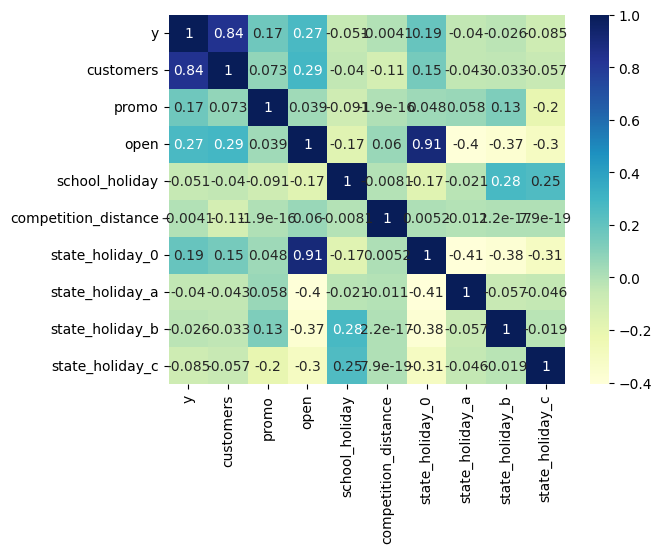

In [56]:
#correlatşon plot
# Import necessary modules
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Compute correlation matrix
co_mtx = weekly_data.corr(numeric_only=True)

# Print correlation matrix
print(co_mtx)

# Plot correlation heatmap
sns.heatmap(co_mtx, cmap="YlGnBu", annot=True)

# Display heatmap
plt.show()

In [63]:
df = weekly_data.copy()
# ADD LAG FEATURES
# -----------------------------
def add_lags(df, lags):
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby("unique_id")["y"].shift(lag)
    return df

# Choosing lags: Based on domain knowledge (weekly sales patterns) and experimentation
weekly_data = add_lags(weekly_data, lags=[1, 2, 4, 13, 52])
weekly_data.dropna(inplace=True)
weekly_data.head()


,unique_id,week,y,customers,promo,open,school_holiday,store_type,assortment,competition_distance,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c,lag_1,lag_2,lag_3,lag_4,lag_13,lag_52
64,store_1,2014-03-25,24786,3062,1,6,0,c,a,1270.0,7,0,0,0,26860.0,25105.0,28211.0,27969.0,22166.0,27763.0
65,store_1,2014-04-01,27885,3268,4,6,0,c,a,1270.0,7,0,0,0,24786.0,26860.0,25105.0,28211.0,22888.0,29913.0
66,store_1,2014-04-08,26828,3295,1,6,1,c,a,1270.0,7,0,0,0,27885.0,24786.0,26860.0,25105.0,27800.0,28760.0
67,store_1,2014-04-15,24608,2679,4,4,7,c,a,1270.0,5,0,2,0,26828.0,27885.0,24786.0,26860.0,26108.0,24283.0
68,store_1,2014-04-22,24178,3068,1,6,4,c,a,1270.0,7,0,0,0,24608.0,26828.0,27885.0,24786.0,27555.0,29128.0


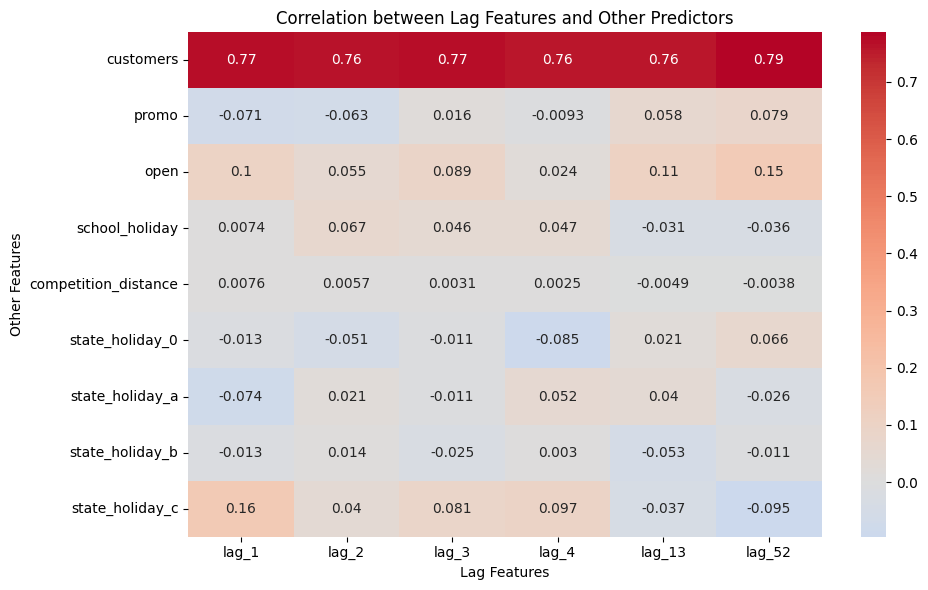

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Extract lag columns and feature columns
lag_cols = [col for col in weekly_data.columns if col.startswith("lag_")]
feature_cols = [col for col in weekly_data.columns 
                if col not in lag_cols + ['unique_id', 'week', 'y'] and weekly_data[col].dtype != 'object']

# Step 2: Compute correlation matrix (features x lags)
correlation_matrix = pd.DataFrame(index=feature_cols, columns=lag_cols)

for feature in feature_cols:
    for lag in lag_cols:
        correlation_matrix.loc[feature, lag] = weekly_data[feature].corr(weekly_data[lag])

correlation_matrix = correlation_matrix.astype(float)  # Ensure numeric

# Step 3: Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Lag Features and Other Predictors")
plt.xlabel("Lag Features")
plt.ylabel("Other Features")
plt.tight_layout()
plt.show()
